In [1]:
include("../src.jl")

itproot

# Задания

<!--
## Нули полинома Лежандра

```{margin}
Которые служат узлами для {ref}`квадратуры Гаусса <definition:gauss_quadrature>`.
```
Методом Риддерса найдите нули полинома Лежандра $L_7$

```{math}
L_7(x) = \frac{1}{16}(429 x^7 - 693 x^5 + 315 x^3 - 35 x).
```
-->

## Вычисление квадратного корня

Напишите функцию `mysqrt(x)`, вычисляющую квадратный корень $\sqrt{x}$ для неотрицательного $x \ge 0$.
Сравните невязку написанной вами функции со стандартной функцией `sqrt(x)` в диапазоне `range(0, 10; step=0.1)`.

## Уравнение фазовых концентраций

Уравнение фазовых концентраций (Rachford-Rice equation) используется для расчётов парожидкостного равновесия смеси веществ {cite}`Brusilovsky2002`. Уравнение выводится из массового баланса веществ в каждой фазе и представляет собой

$$
F(G) = \sum_{i} \frac{z_i \times (K_i - 1)}{G \times (K_i - 1) + 1} = 0,
$$

где $z_i$ мольная доля $i$-го компонента в смеси, $K_i$ константа равновесия $i$-го компонента (отношение мольной доли компонента в газе к его мольной доли в жидкости) и $G$ мольная доля газа в двухфазном состоянии.

Решение этого уравнения показывает мольную долю газа в двухфазном состоянии при соответствующем распределении компонентов по жидкой и газовой фазе.

Можно показать {cite}`Brusilovsky2002`, что решение уравнения стоит искать в интервале

$$
1 / (1 - \max K_i) \quad \ldots \quad 1 / (1 - \min K_i).
$$

Этот интервал содержит в себе физические значения 
мольной доли газа $G$, а функция $F(G)$ на нём убывает.

**Задание**

Напишите функцию `rachford_rice_solve(z, K) -> G`, решающую уравнение фазовых концентраций.
Постройте графики функции $F(G)$ с нанесённым корнем $F(G) = 0$ для случаев

- $z = [0.9, 0.1]$, $K = [1.5, 0.01]$;
- $z = [0.2463, 0.2208, 0.2208, 0.3121]$, $K = [40, 25, 0.6, 0.005]$.

Для построения графиков воспользуйтесь пакетом [Plots.jl](https://docs.juliaplots.org/stable/).


(ex_vdw_binodal_lekner)=
## Бинодаль уравнения состояния ван дер Ваальса

```{note}
В этом задании вам предстоит найти область двухфазного равновесия для уравнения состояния ван дер Ваальса.
```

В приведённых величинах $P_r = P / P_c$, $V_r = V / V_c$, $T_r = T / T_c$ уравнение ван дер Ваальса имеет вид

```{math}
P_r(V_r, T_r) = \frac{8 T_r}{3 V_r - 1} - \frac{3}{V_r^2}.
```

Несложно построить набор изотерм.

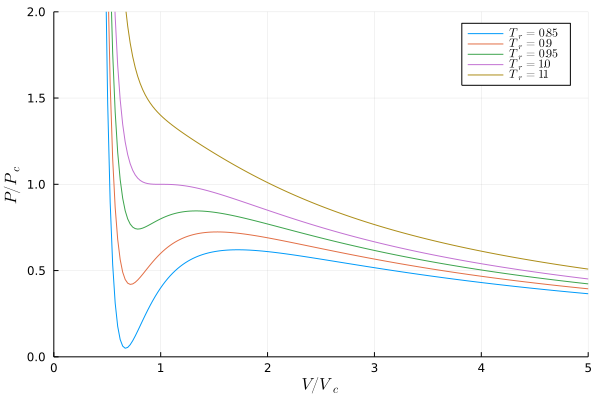

In [2]:
pressure(Vr::Real, Tr::Real) = 8Tr / (3Vr - 1) - 3 / Vr^2
V = range(0.34, 5; length=200)
plt = plot(;
    ylim=(0, 2),
    xlim=(0, 5),
    xlabel=L"V/V_c",
    ylabel=L"P/P_c",
    lw=2,
)
for Tr in (0.85, 0.9, 0.95, 1.0, 1.1)
    plot!(V, pressure.(V, Tr); label=L"T_r = %$(Tr)")
end
plt

Рассмотрим подробнее изотерму для докритической температуры $T^* \in (0, T_c)$.

```{figure} vdw_isotherm.png
---
height: 480px
---
Изотерма ван дер Ваальса при температуре ниже критической.
```

Красный участок на изотерме соответствует запрещённым термодинамическим состояниям, поскольку $\partial P_r / \partial V_r > 0$. Жёлтый участок изобары $P_X$ соответствует давлению, при котором при данной температуре $T^*$ жидкая и газовая фазы сосуществуют. При объёмах $V_r < V_L$ всё вещество находится в жидком состоянии, а при объёмах $V_r > V_G$ в газовом. Синий и зелёный участки изотермы соответствуют метастабильным состояниям.

Можно вычилисть ряд величин $V_L$ и $V_G$ для диапазона температур, тогда получим границу двухфазной области.


```{figure} vdw_task_answer.svg
---
height: 480px
name: nlroot_vdw_task_answer
---
Уравнение ван дер Ваальса. Сплошными линиями показаны изотермы для ряда температур. Красная линия с точками соответствует бинодали: это граница значений давлений и объёмов $V_L$, $V_G$, при которых возможно двухфазное состояние. Красная область под бинодалью -- двухфазная область.
```

Чтобы для данной температуры $T^*$ определить равновесные объёмы $V_G$, $V_L$ и давление $P_X$, требуется находить минимум потенциала Гельмгольца. Это требует решения нелинейной системы, но можно поступить иначе.

Лекнером {cite}`lekner1982` предложена параметризация величин для двухфазного равновесия. В качестве параметра используется $y = \Delta s / 2$, где $\Delta s$ представляет собой скачок энтропии на частицу между газовой и жидкой фазами в единицах $k_B$. Для параметризации используются функции $f(y)$ и $g(y)$

```{math}
\begin{align}
f(y) &= \frac{y \cosh{y} - \sinh{y}}{\sinh{y}\cosh{y}-y},\\
g(y) &= 1 + 2 f(y) \cosh{y} + f^2(y),
\end{align}
```

через которые выражаются термодинамические величины.

Так, приведённые температура $T_X$ и давление $P_X$ задают $(P, T)$-границу двухфазного равновесия. Функции параметризованы следующим образом

```{math}
\begin{align}
T_X(y) &= \frac{27 f(y)[f(y) + \cosh{y}]}{4g^2(y)},\\
P_X(y) &= \frac{27 f^2(y)[1 - f^2(y)]}{g^2(y)}.\\
\end{align}
```

**Задание**

Ваша задача состоит в том, чтобы определить $V_L$ и $V_G$ для ряда температур $T_r \in [0.85, 1]$ и соответствующих им давлений, получив таким образом границу фазового равновесия. Нанесите полученные точки $(P_X, V_L)$ и $(P_X, V_G)$ поверх изотерм, как на {numref}`Рисунке %s <nlroot_vdw_task_answer>`.

```{tip}
Подробную информацию об уравнении ван дер Ваальса можно получить из статьи {cite}`Johnston2014`.
```